In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import brownian_sde, trace_brownian_sde, reverse
from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse, butterfly1_pts, butterfly2_pts

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
N=100
dim=2
num_bases = 5
sigma=0.05


In [4]:
def fourier_coefficients(array, num_bases):
    """Array of shape [..., pts, dim]
    Returns array of shape [..., :2*num_bases, dim]"""
    
    complex_coefficients = jnp.fft.rfft(array, norm="forward", axis=-2)[..., :num_bases, :]
    coeffs = jnp.stack([complex_coefficients.real, complex_coefficients.imag], axis=0)
    coeffs = coeffs.reshape(*complex_coefficients.shape[:-2], -1, complex_coefficients.shape[-1])
    return coeffs

def inverse_fourier(coefficients, num_pts):
    """Array of shape [..., 2*num_bases, dim]
    Returns array of shape [..., num_pts, dim]"""
    assert coefficients.shape[-2] % 2 == 0
    num_bases = int(coefficients.shape[-2]/2)
    coeffs_real = coefficients[..., :num_bases, :]
    coeffs_im = coefficients[..., num_bases:, :]
    complex_coefficients = coeffs_real + 1j*coeffs_im
    return jnp.fft.irfft(complex_coefficients, norm="forward", n=num_pts, axis=-2)    

In [5]:
butterfly = jnp.array(butterfly1_pts())[:, ::1861][:, ::1].T

butterfly_coeffs = fourier_coefficients(butterfly, num_bases)
butterfly_recon = inverse_fourier(butterfly_coeffs, 120)

print(butterfly_recon.shape)
print(butterfly_coeffs.shape)

(120, 2)
(10, 2)


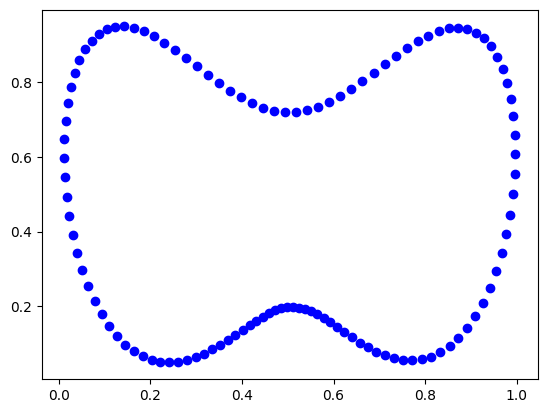

In [6]:
plt.scatter(butterfly_recon[:, 0], butterfly_recon[:, 1], c="b")

In [8]:
bm_sde = brownian_sde(T, N, dim, 2*num_bases, sigma)
key = jax.random.PRNGKey(2)
forward_trajs = bm_sde.simulate_trajectories(butterfly_coeffs, 2, key)

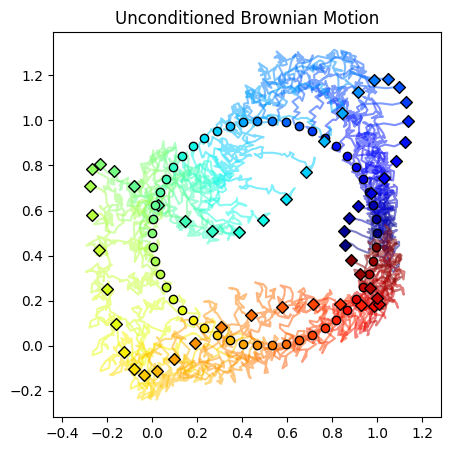

In [9]:
from sdebridge.plotting import plot_single_trajectory

forward_traj_coeffs = forward_trajs[0]
forward_traj = inverse_fourier(forward_traj_coeffs, 50)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


In [10]:
trace_bm_sde = trace_brownian_sde(T, N, dim, 2*num_bases, alpha=0.1, power=2)
key = jax.random.PRNGKey(2)
forward_trajs_trace = trace_bm_sde.simulate_trajectories(butterfly_coeffs, 2, key)

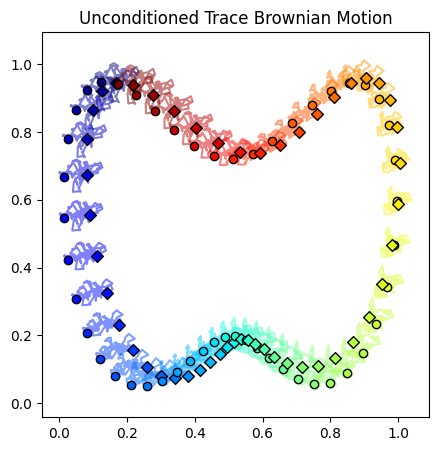

In [11]:
forward_trace_coeffs = forward_trajs_trace[0]
forward_trace = inverse_fourier(forward_trace_coeffs, 50)
traj = forward_trace.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Trace Brownian Motion")

In [12]:
bm_db = DiffusionBridge(bm_sde)

In [23]:
from sdebridge.networks.score_unet import ScoreUNet
setup_params = {
    "neural_net": ScoreUNet,
 
    "network": {
        "output_dim": bm_db.sde.dim*bm_db.sde.n_bases,
        "time_embedding_dim": 32,
        "init_embedding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [64, 32, 16, 8],
        "decoder_layer_dims": [8, 16, 32, 64],
        "batchnorm": True,
    },
    
    "training": {
        "batch_size": 100,
        "load_size": 5000,
        "num_epochs": 100,
        "learning_rate": 5e-3,
        "warmup_steps": 0,
    }
}

target = butterfly_coeffs
train_key = jax.random.split(key, 2)[0]
score_p_state = bm_db.learn_p_score(target, train_key, setup_params)

Training: 100%|██████████| 100/100 [05:24<00:00,  3.25s/epoch, Epoch=100, loss=9.4147]


In [31]:
initial_pts = jnp.array(butterfly2_pts())[:, ::475][:, ::1].T
initial_coeffs = fourier_coefficients(initial_pts, num_bases)
print(initial_pts.shape)
print(initial_coeffs.shape)

reverse_sde = reverse(bm_sde, score_fn(score_p_state))
backward_coeffs = reverse_sde.simulate_trajectories(initial_coeffs, 2, key)

forward_coeffs = bm_sde.simulate_trajectories(initial_coeffs, 2, key)


(120, 2)
(10, 2)


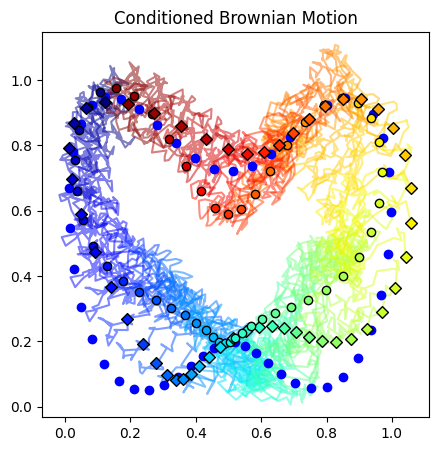

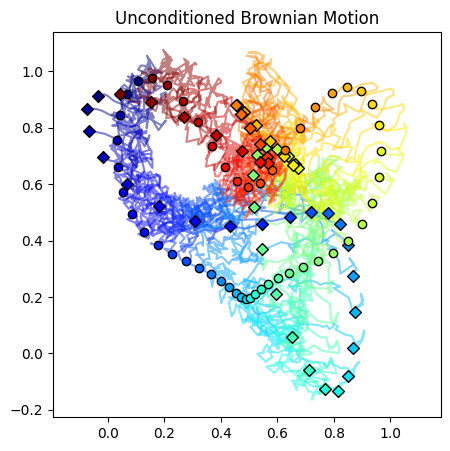

In [32]:
backward_traj = inverse_fourier(backward_coeffs[0], 50)
traj = backward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Conditioned Brownian Motion")
target_plt = inverse_fourier(target, 50)
plt.scatter(target_plt[:, 0], target_plt[:, 1], c="b")

forward_traj = inverse_fourier(forward_coeffs[0], 50)
traj = forward_traj.reshape((N, -1))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


(2, 100, 10, 2)


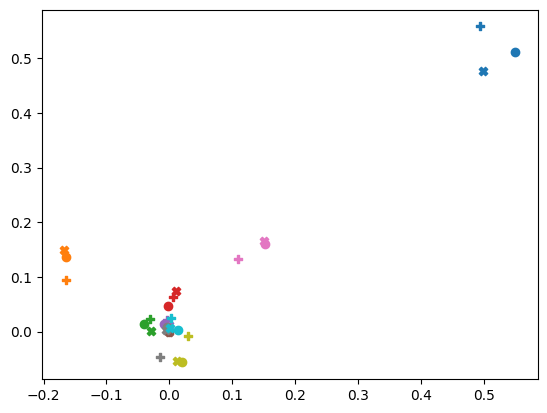

In [36]:
# plot target coefficients vs backward trajectory last coefficients

plt_backward_coeffs = backward_coeffs[0]
print(backward_coeffs.shape)

for i, coeff in enumerate(range(2*num_bases)):
    plt.scatter(plt_backward_coeffs[-1, coeff, 0], plt_backward_coeffs[-1, coeff, 1], color=f"C{i}")
    plt.scatter(plt_backward_coeffs[0, coeff, 0], plt_backward_coeffs[0, coeff, 1], color=f"C{i}", marker="P")

    # plt.plot(plt_backward_coeffs[:, coeff, 0], plt_backward_coeffs[:, coeff, 1], color=f"C{i}")
    plt.scatter(target[coeff, 0], target[coeff, 1], color=f"C{i}", marker="X")
    
# 
# for i, coeff in enumerate(range(1)):
#     plt.scatter(forward_coeffs[0, -1, coeff, 0], forward_coeffs[0, -1, coeff, 1], color='r')
#     plt.scatter(forward_coeffs[0, 0, coeff, 0], forward_coeffs[0, 0, coeff, 1], color='r', marker='o')
#     plt.plot(forward_coeffs[0, :, coeff, 0], forward_coeffs[0, :, coeff, 1], color='r')

